# Snow Cover Maps
This notebook computes snow cover maps using [MODIS CGF SNOW COVER](https://nsidc.org/data/mod10a1f/versions/61) data (res. 500m, daily temporal res). The data has been preprocessed and downloaded using the script modis_download.py. 

Maps:
- **Snow Cover Frequency** (percentage snow cover): measures the proportion of days a pixel is snow-covered (value=1-100) relative to the total number of days analyzed.
- **Snow Cover Duration** (days with snow): number of days each pixel is snow-covered (value=50-100).

These maps are computed for 3 different time periods, across 3 years (oct 2021- oct 2024):
- snow season: period of intense snowfalls, accumulation of snow (Oct to Feb)
- melting season: period of snow melt, important for water management catchment (Mar to June)
- late summer: period of minimum snow (July to Sept)


In [3]:
import os
import rasterio
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [4]:
def parse_filename_date(filename):
    """
    Extracts year and day-of-year (DDD) from the filename.
    filename format: MOD[PID].A[YYYY][DDD].h[NN]v[NN].[VVV].[yyyy][ddd][hhmmss].tif
    """
    try:
        base_name = os.path.basename(filename)
        year = int(base_name.split('.')[1][1:5])
        doy = int(base_name.split('.')[1][5:8])
        return year, doy
    except Exception as e:
        print(f"Error parsing date from filename {filename}: {e}")
        return None, None

def select_files_by_period(file_list, start_month, end_month):
    """
    Selects files within the specified time period based on their filenames.
    """
    selected_files = []
    for file in file_list:
        year, doy = parse_filename_date(file)
        if year is not None and doy is not None:
            # Convert year and day-of-year to a datetime object
            file_date = datetime(year, 1, 1) + timedelta(days=doy - 1)
            
            if start_month <= end_month:
                # Regular case: no wrapping (March to June)
                if start_month <= file_date.month <= end_month:
                    selected_files.append(file)
            else:
                # Wrapping case (October to February)
                if file_date.month >= start_month or file_date.month <= end_month:
                    selected_files.append(file)
    return selected_files

def compute_snow_cover_frequency(file_list, output_file=None):
    """
    Computes snow cover frequency over a given time period.
    """
    if not file_list:
        print("No files selected for this period.")
        return
    
    print(f"Computing snow cover frequency for {len(file_list)} files...")
    
    # Initialize array dimensions from first file
    with rasterio.open(file_list[0]) as src:
        profile = src.profile
        profile.update(dtype=rasterio.float32)
        meta = src.meta
        frequency_array = np.zeros((meta['height'], meta['width']), dtype=np.float32)
    
    snow_count = np.zeros_like(frequency_array)
    total_count = np.zeros_like(frequency_array)
    
    # Process each file
    for file in file_list:
        with rasterio.open(file) as src:
            data = src.read(1)
            valid_mask = (data != 200) & (data != 255) # exclude missing data & fill #(data >= 0) & (data <= 100)  # Only consider snow values
            snow_mask = (data > 0) & (data <= 100)   # snow pixels between 1 and 100

            snow_count += snow_mask.astype(np.float32)
            total_count += valid_mask.astype(np.float32)
    
    # Compute frequency
    frequency_array = np.divide(snow_count, total_count, where=total_count > 0)

    # Save snow frequency raster
    if output_file is not None:
        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(frequency_array, 1)

    return frequency_array, output_file

def compute_snow_duration(file_list, snow_thr:int, output_file=None):
    """
    Computes snow cover (daily) duration (above snow_thr) over a given time period.
    """
    if not file_list:
        print("No files selected for this period.")
        return
    
    print(f"Computing snow cover duration for {len(file_list)} files...")

    # Initialize snow duration array
    snow_duration = None
    metadata = None
    
    for file in file_list:
        with rasterio.open(file) as src:
            data = src.read(1)  # Read the first band
            snow_mask = (data > snow_thr) & (data <= 100)  # Snow-covered pixels
            
            if snow_duration is None:
                snow_duration = np.zeros_like(data, dtype=np.uint16)
                metadata = src.meta.copy()
            
            snow_duration += snow_mask.astype(np.uint16)

    # Save the snow duration raster
    if metadata is not None and output_file is not None:
        metadata.update(dtype="uint16", count=1, compress="lzw")
        with rasterio.open(output_file, "w", **metadata) as dst:
            dst.write(snow_duration, 1)
        
    return snow_duration, output_file

In [5]:
INPUT_DIR = "/Volumes/TOSHIBA_EXT/MODIS_RASTERS_large"
OUTPUT_DIR = "../data/maps/maps_large"
TIME_PERIODS = {
    "snow_season": (10, 2),  # October to February
    "melting_season": (3, 6),  # March to June
    "late_summer": (7, 9),  # July to September
}

all_files = [os.path.join(INPUT_DIR, f) for f in os.listdir(INPUT_DIR) if f.endswith(".tif")]

for i, (period_name, (start_month, end_month)) in enumerate(TIME_PERIODS.items()):
    print(f"Processing period: {period_name}")
    selected_files = select_files_by_period(all_files, start_month, end_month)
    
    output_file = os.path.join(OUTPUT_DIR, f"SCF_{period_name}.tif")
    frequency_array, map_file = compute_snow_cover_frequency(selected_files, output_file)

    output_file = os.path.join(OUTPUT_DIR, f"SCD_{period_name}.tif")
    duration_array, map_file = compute_snow_duration(selected_files, 50, output_file)


Processing period: snow_season
Computing snow cover frequency for 455 files...
Computing snow cover duration for 455 files...
Processing period: melting_season
Computing snow cover frequency for 366 files...
Computing snow cover duration for 366 files...
Processing period: late_summer
Computing snow cover frequency for 276 files...
Computing snow cover duration for 276 files...


In [ ]:
# Single plot
plt.imshow(duration_array, cmap='binary')
plt.colorbar()
plt.title(f"SCD ({period_name})")
plt.show()

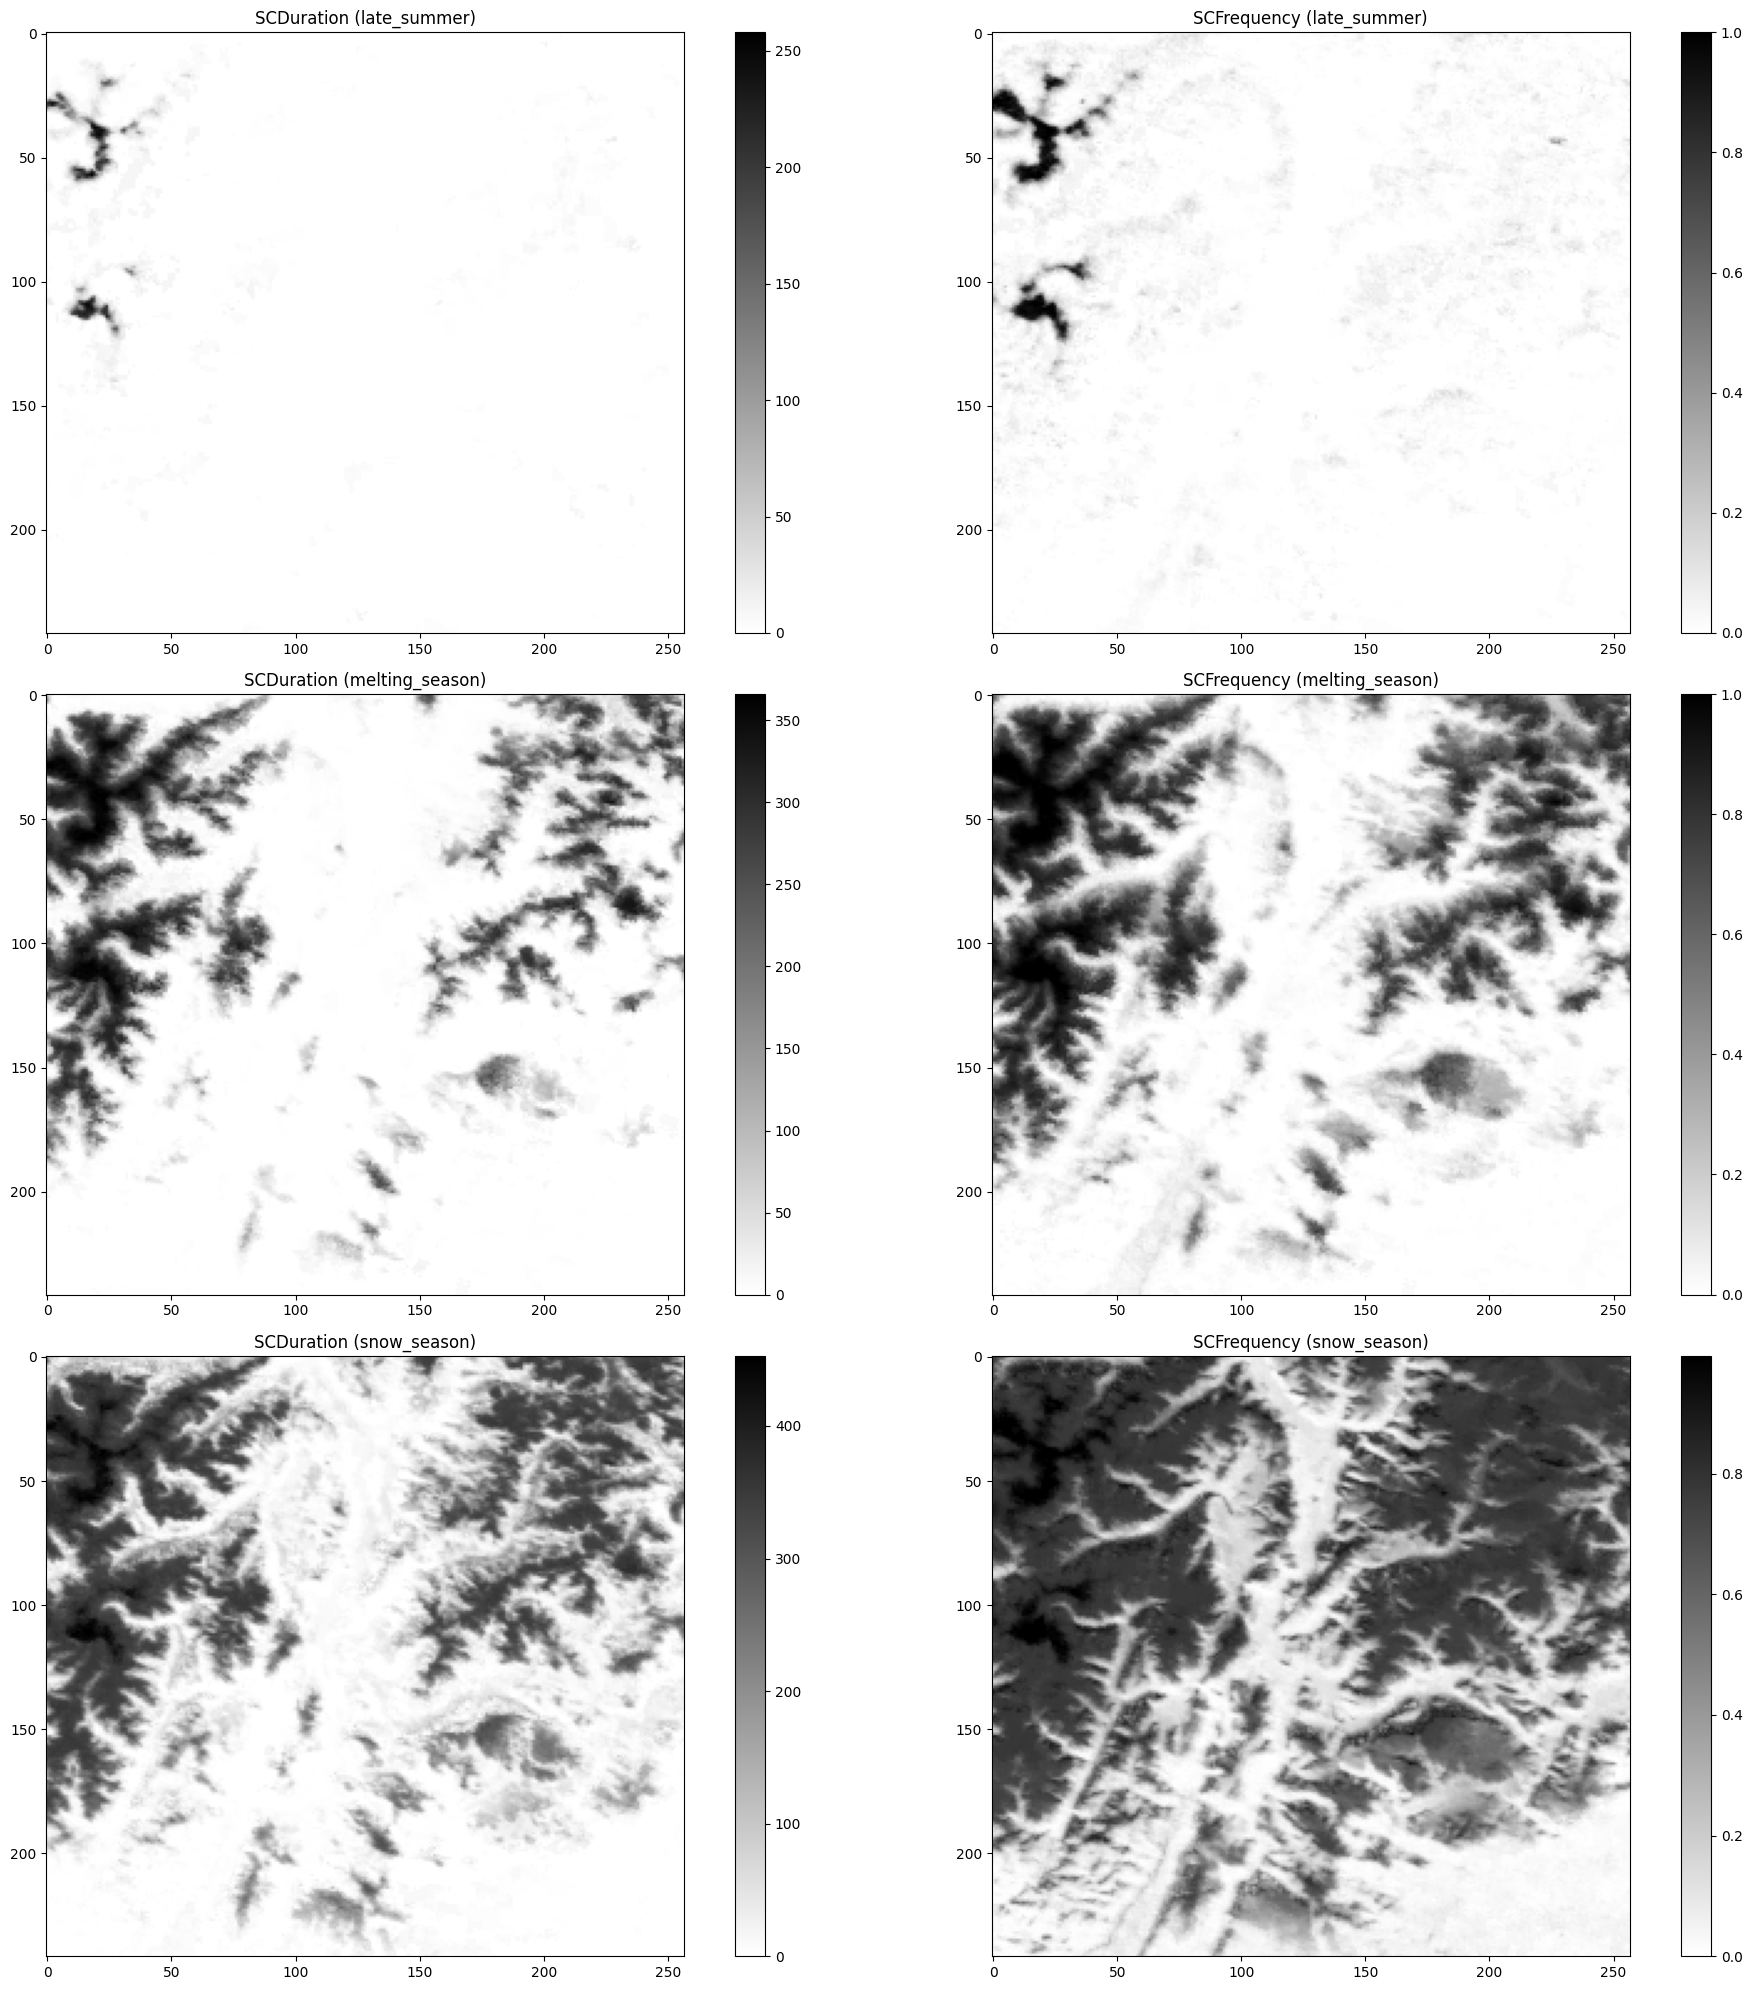

In [7]:
# Plot all maps
results_SCD = ['../data/maps/maps_large/SCD_late_summer.tif',
'../data/maps/maps_large/SCD_melting_season.tif',
'../data/maps/maps_large/SCD_snow_season.tif']

results_SCF = ['../data/maps/maps_large/SCF_late_summer.tif',
'../data/maps/maps_large/SCF_melting_season.tif',
'../data/maps/maps_large/SCF_snow_season.tif']

fig, ax = plt.subplots(3, 2, figsize=(20,20))
i = 0
for file_scd, file_scf in zip(results_SCD, results_SCF):
    
    with rasterio.open(file_scd) as src:
        scd = src.read(1)
    
    period_name_scd = '_'.join(os.path.basename(file_scd).split('.')[0].split('_')[-2:])

    with rasterio.open(file_scf) as src:
        scf = src.read(1)

    period_name_scf = '_'.join(os.path.basename(file_scf).split('.')[0].split('_')[-2:])
    assert period_name_scf == period_name_scd

    ax[i, 0].imshow(scd, cmap='binary')
    plt.colorbar(ax[i, 0].imshow(scd, cmap='binary'), ax=ax[i, 0])
    ax[i, 0].set_title(f"SCDuration ({period_name_scd})")

    ax[i, 1].imshow(scf, cmap='binary')
    plt.colorbar(ax[i, 1].imshow(scf, cmap='binary'), ax=ax[i, 1])
    ax[i, 1].set_title(f"SCFrequency ({period_name_scf})")
    
    i += 1

plt.tight_layout()
plt.show()
